In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

# Data Preparation

## Reading in Data

In [177]:
import pandas as pd
df = pd.read_csv("wba_data_CLEAN.csv")

# Removing unnecessary columns
df = df.drop(columns = ["Unnamed: 0", "Subject"])

In [178]:
df[df.columns[:14]]

,Gender,AgeY,ECV,TPP,SC,TympType,OAE1,OAE1.4,OAE2,OAE2.8,OAE4,OverallPoF,Ear coded,Pressure
0,0,9.333333,1.08,-189.0,0.52,1,3.0,10.0,18.0,14.0,8.0,1,0,-1
1,0,9.500000,1.28,-49.0,1.28,0,7.0,4.0,9.0,5.0,6.0,0,0,-4
2,1,9.833333,1.26,-27.0,0.87,0,9.0,12.0,8.0,12.0,16.0,0,0,-4
3,0,9.916667,0.64,-8.0,0.60,0,13.0,9.0,13.0,11.0,12.0,0,0,2
4,0,7.916667,0.92,-17.0,1.65,0,7.0,0.0,2.0,12.0,6.0,1,0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,1,8.666667,1.18,-48.0,1.07,0,10.3,18.6,12.0,0.5,3.7,0,1,1
235,0,8.666667,0.78,-17.0,0.77,0,13.2,23.5,17.3,14.3,6.7,0,1,-4
236,1,8.833333,0.90,2.0,1.02,0,5.3,11.0,15.3,14.6,11.5,0,1,-5
237,1,8.250000,0.76,-173.0,0.15,1,-3.6,-0.9,-2.4,3.0,3.0,1,1,-5


There are many issues with scaling and negative data that we will have to deal with. 

By default, we will only use the frequencies and dependent variable (`OverallPoF`).\
If you wish to include any other control variables, put them in the `desired_controls` list, but beware of dodgy results unless its values lie within 0 and 1.\
If changing the number of variables, make sure to change the number of inputs in the VAE class.

## Column Selection

In [179]:
desired_controls = ["TympType"]

In [180]:
desired_cols = [c for c in df.columns if c[:2] == "f(" or c == "OverallPoF" or c in desired_controls]

In [181]:
# Creating new dataframe to alter
wba_df = df[desired_cols].copy(deep=True)

# Turning dataframe into tensor
batch_size = 32
train_data = torch.tensor(wba_df.values, dtype=torch.float32)
train_data

tensor([[1.0000, 1.0000, 0.0987,  ..., 0.2530, 0.2282, 0.2003],
        [0.0000, 0.0000, 0.1114,  ..., 0.2048, 0.1917, 0.1659],
        [0.0000, 0.0000, 0.1096,  ..., 0.3237, 0.3056, 0.2881],
        ...,
        [0.0000, 0.0000, 0.1016,  ..., 0.3136, 0.2871, 0.2679],
        [1.0000, 1.0000, 0.0366,  ..., 0.0612, 0.0427, 0.0031],
        [1.0000, 1.0000, 0.0267,  ..., 0.4081, 0.3874, 0.3852]])

## Training data loader

In [182]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

# Variational Autoencoder

## Encoder and Decoder

In [183]:
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        self.wba_input_size = 109
        self.latent_dim = 16

        # Symmetrical encoder and decoder
        
        # encoder
        self.enc1 = nn.Linear(in_features=self.wba_input_size, out_features=self.wba_input_size//2)
        self.enc2 = nn.Linear(in_features=self.wba_input_size//2, out_features=self.wba_input_size//3)
        self.enc3 = nn.Linear(in_features=self.wba_input_size//3, out_features=self.latent_dim*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=self.latent_dim, out_features=self.wba_input_size//2)
        self.dec2 = nn.Linear(in_features=self.wba_input_size//2, out_features=self.wba_input_size//3)
        self.dec3 = nn.Linear(in_features=self.wba_input_size//3, out_features=self.wba_input_size)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def encode(self, x):
        # encoding
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = self.enc3(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        return mu, log_var

    def decode(self, z):
        x = F.leaky_relu(self.dec1(z))
        x = F.leaky_relu(self.dec2(x))
        reconstruction = torch.sigmoid(self.dec3(x))
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var
    
    def sample(self, num_samples, current_device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x):
        return self.forward(x)[0]

## Loss function

In [184]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.BCELoss(reduction='sum')

In [185]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss 
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Model Training

In [186]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [187]:
epochs = 1000
for epoch in range(epochs):
    # print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    # print(f"Train Loss: {train_epoch_loss:.4f}")

8it [00:00, 428.31it/s]              
8it [00:00, 536.88it/s]              
8it [00:00, 506.58it/s]              
8it [00:00, 511.01it/s]              
8it [00:00, 551.38it/s]              
8it [00:00, 516.36it/s]              
8it [00:00, 550.05it/s]              
8it [00:00, 553.86it/s]              
8it [00:00, 642.17it/s]              
8it [00:00, 527.78it/s]              
8it [00:00, 553.44it/s]              
8it [00:00, 586.98it/s]              
8it [00:00, 609.80it/s]              
8it [00:00, 634.12it/s]              
8it [00:00, 579.62it/s]              
8it [00:00, 555.09it/s]              
8it [00:00, 534.72it/s]              
8it [00:00, 620.34it/s]              
8it [00:00, 577.58it/s]              
8it [00:00, 590.53it/s]              
8it [00:00, 659.20it/s]              
8it [00:00, 558.14it/s]              
8it [00:00, 448.18it/s]              
8it [00:00, 453.00it/s]              
8it [00:00, 533.25it/s]              
8it [00:00, 560.33it/s]              
8it [00:00, 

# Generated Samples

## Extracting Sample Data

In [188]:
### Generated samples (tensor)
generated_samples = model.sample(1000, device)
generated_samples = generated_samples.cpu().detach()
generated_samples

### Generated dataframe
generated_df = pd.DataFrame(generated_samples)

# Renaming columns
generated_df.columns = wba_df.columns

# Generated frequencies dataframe (for plotting)
freq_cols = [c for c in generated_df.columns if c[0:2] == "f("]
gen_freqs = generated_df[freq_cols]

## Re-Scaling

### Rounding Binary Variables

In [ ]:
generated_df['OverallPoF'] = round(generated_df['OverallPoF'])

In [ ]:
for cont in desired_controls:
    generated_df[cont] = round(generated_df[cont)

## WBA vs. Frequencies

### Generated Data

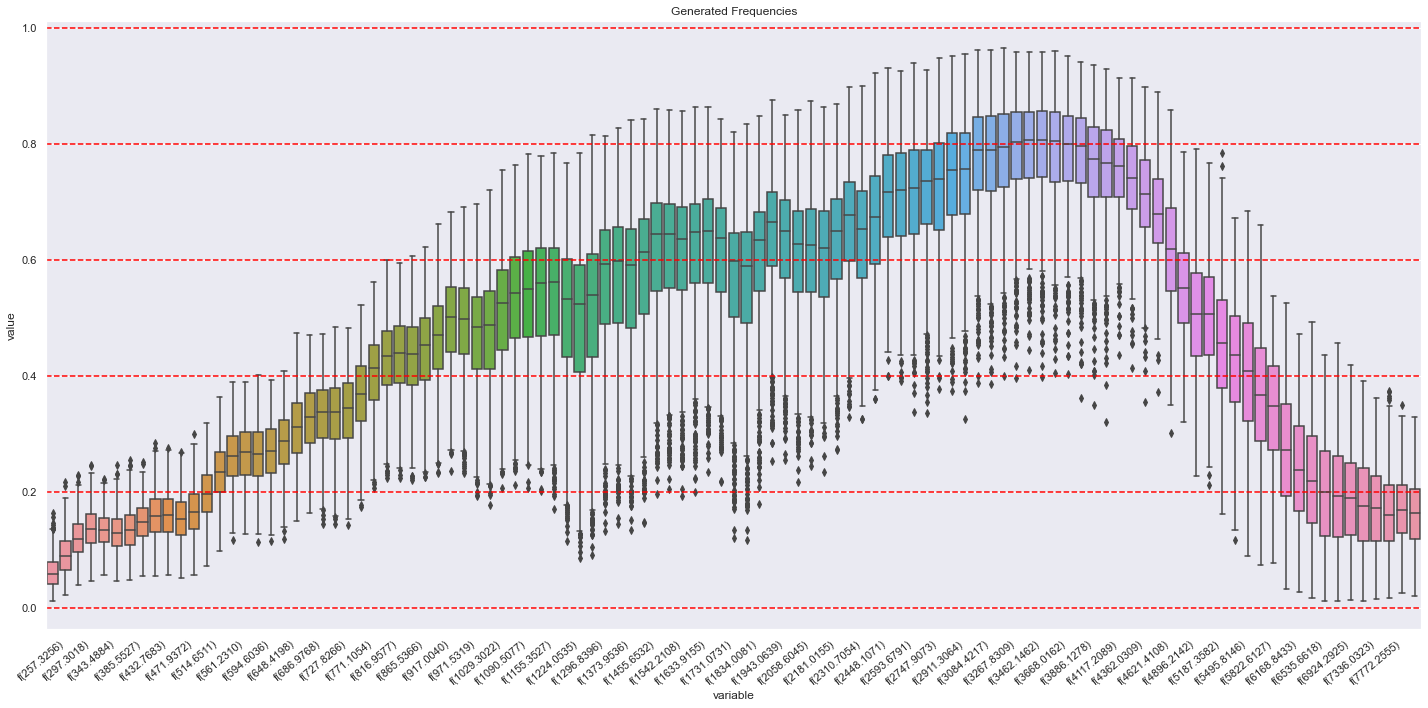

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20,10)})

gen_freqs_long = gen_freqs.melt()
ax = sns.boxplot(x="variable", y="value", data=gen_freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Generated Frequencies")

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

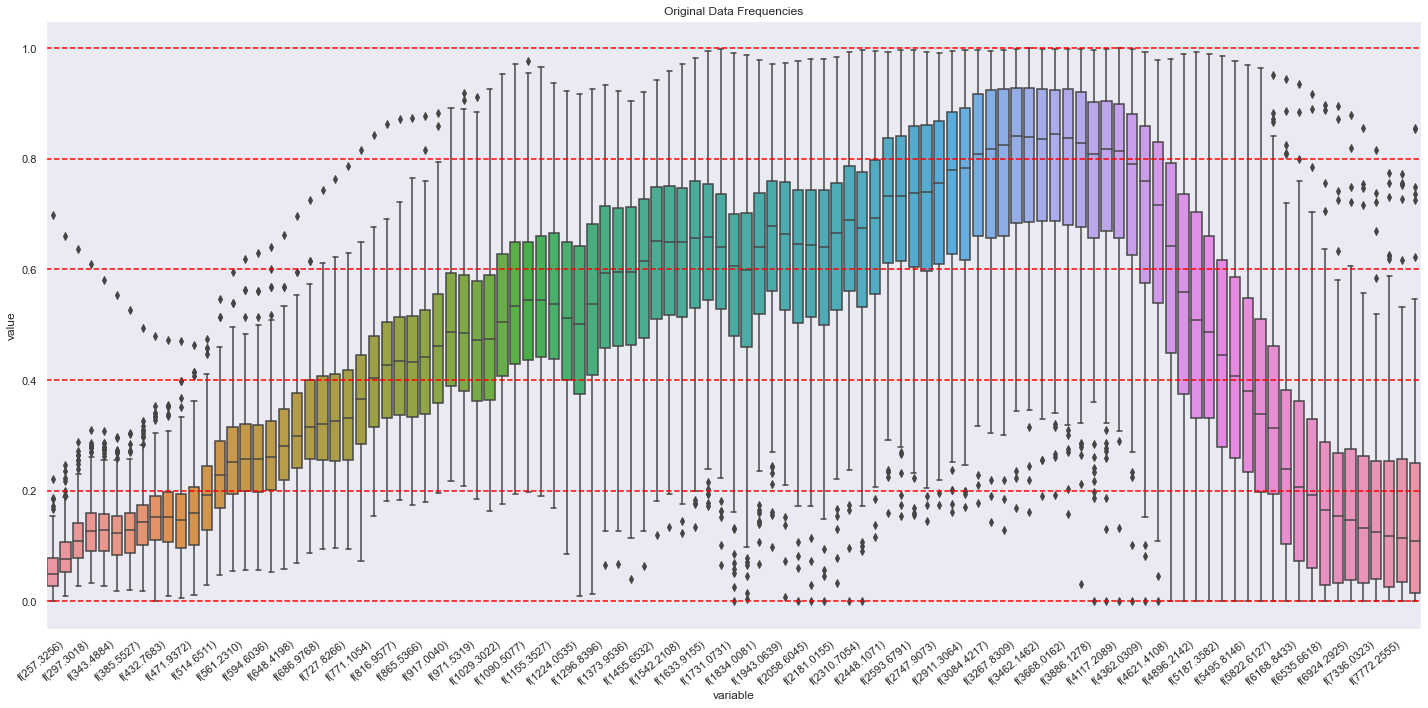

In [192]:
wba_df_long = wba_df[freq_cols].melt()

sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="variable", y="value", data=wba_df_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Original Data Frequencies')
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

## Frequencies vs. OverallPoF

### Generated

In [ ]:
gen_overall_pof = generated_df[['OverallPoF'] + freq_cols]
gen_overall_pof = gen_overall_pof.replace({'OverallPoF':{0: 'Pass', 1: 'Fail'}})
gen_overall_pof = gen_overall_pof.groupby('OverallPoF').mean()
gen_overall_pof = gen_overall_pof.melt(ignore_index=False)
gen_overall_pof = gen_overall_pof.reset_index()

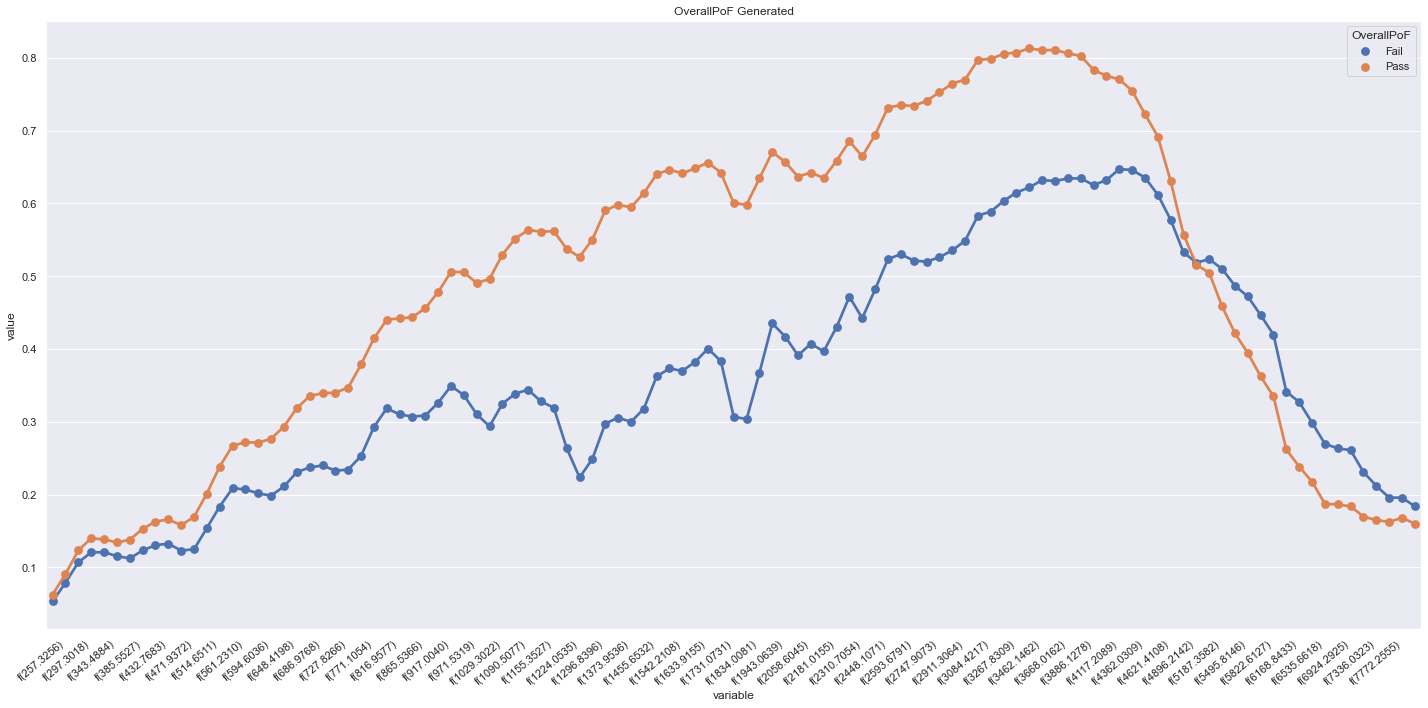

In [204]:
# Plotting
ax = sns.pointplot(x='variable', y='value', hue='OverallPoF', data=gen_overall_pof)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="OverallPoF Generated")

# Show only every 2 tick labels on x-axis
sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.tight_layout()
plt.show();

### Original

In [199]:
overall_pof_df = wba_df[['OverallPoF'] + freq_cols]
overall_pof_df = overall_pof_df.replace({'OverallPoF':{0: 'Pass', 1: 'Fail'}})
overall_pof_df = overall_pof_df.groupby('OverallPoF').mean()
overall_pof_df = overall_pof_df.melt(ignore_index=False)
overall_pof_df = overall_pof_df.reset_index()

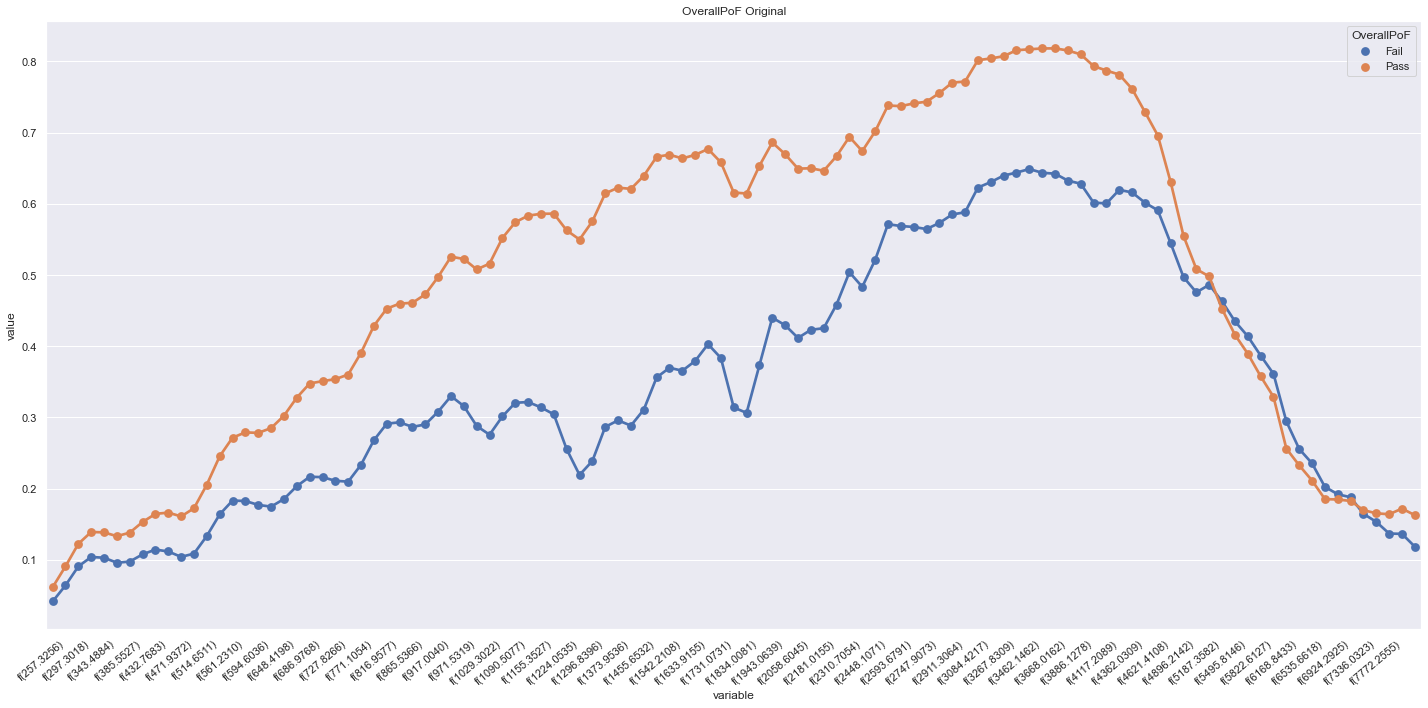

In [203]:
# Plotting
ax = sns.pointplot(x='variable', y='value', hue='OverallPoF', data=overall_pof_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="OverallPoF Original")

# Show only every 2 tick labels on x-axis
sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.tight_layout()
plt.show();